In [2]:
from adodbapi.examples.xls_read import driver
from selenium import webdriver
from selenium.webdriver.common.by import By
import pickle
import time
import random
from gpt_chat import AsyncOpenAIChatAgent

from config import OPENAI, PROXIES, NUUM, POLINA_CLIPS, CLIPS, cookie_path


In [56]:
def img_stiker(s):
    s.get_attribute('src')
    # load stiker from url
    # example: 'https://static.nuum.ru/sticker-packs/seal/webp/medium/seal-14.webp'
    import requests
    import io
    from PIL import Image

    url = s.get_attribute('src')
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content))

    return img

def rnd_sleep(m=1, d=1.5):
    # normal distribution
    sleep = random.normalvariate(m, d)
    #print(sleep)
    time.sleep(max(.5,sleep))

class Elm:
    def __init__(self, el):
        self.class_ = el.get_attribute('class')
        self.text = el.text
        self.tag = el.tag_name
        self.el = el
        self.url = el.get_attribute('src')
        self.pos = el.location
        self.link = el.get_attribute('href')
        
    def click(self):
        self.el.click()
        
    def get_attribute(self, attr):
        return self.el.get_attribute(attr)
        

class NuumBaseAction:
    def __init__(self, driver):
        self.driver = driver
        self.gpt = AsyncOpenAIChatAgent(OPENAI, proxies=ROXIES)
        self.tmp = None
        
    def find_description(self):
        description_element = self.driver.find_element(By.XPATH, "//app-text-cropper//span[contains(@class, 'text--full')]")
        description_text = self.driver.execute_script("return arguments[0].textContent;", description_element)
        return description_text
    
    def open(self, url):
        self.driver.get(url)
        self.driver.implicitly_wait(5)
        
    def like(self, click_liked=False):
        like_button = self.find_like_button()
        if like_button:            
            active = 'active' in like_button.class_
            if not active or click_liked:
                like_button.click()
                return True
        return False
    
    def subscribe(self):
        sbscrs = self.driver.find_elements(By.XPATH, "//span[contains(text(), 'Подписаться')]")
        sbscrs = [Elm(s) for s in sbscrs] 
        sbscrs = [s for s in sbscrs if self.in_screen(s)]
        if sbscrs:
            sbscrs[0].click()
            return True
        return False
            
    def send_stiker(self):
        # comment-input__smile-button ng-star-inserted
        element = self.driver.find_elements(By.XPATH, "//button[contains(@class, 'comment-input__smile-button')]")
        
        if element:
            rnd_sleep()
            element[0].click()
        
        element = self.driver.find_elements(By.XPATH, "//span[contains(text(), 'Стикеры')]")

        if element:
            rnd_sleep()
            element[0].click()
        
        rnd_sleep()        
        d = self.driver.find_elements(By.XPATH, "//div[contains(@class, 'smiles__navigation-sticker-wrapper')]")
        if d:
            d = random.choice(d)
            d.click()
            time.sleep(1)
                
        stikers_div = self.driver.find_elements(By.XPATH, "//div[contains(@class, 'sticker ng-star-inserted')]")
        stikers = []
        for s in stikers_div:
            stiker = s.find_elements(By.CSS_SELECTOR, '*')
            if stiker:
                if stiker[0].get_attribute('src'):
                    stikers.append(stiker[0])
        
        if stikers:
            stiker = random.choice(stikers)
            stiker.click()
            return True
        return False
            
    def send_comment(self, text):
        textarea = self.driver.find_elements(By.NAME, 'commentInput')
        if textarea:
            textarea = textarea[0]
            #textarea[0].send_keys(text)    
            driver.execute_script("""
    var textarea = arguments[0];
    console.log('Тип textarea:', textarea.constructor.name);
    console.log('Имеет dispatchEvent:', typeof textarea.dispatchEvent);

    textarea.value = arguments[1];

    var event = document.createEvent('Event');
    event.initEvent('input', true, true);
    textarea.dispatchEvent(event);
""", textarea, text)
        button = self.driver.find_elements(By.XPATH, "//button[contains(@class, 'input-form__send-button')]")
        if button:
            button[0].click()
        
    def get_clips_from_page(self):
        elements = self.driver.find_elements(By.XPATH, "//a[contains(@href, '/channel/') and contains(@href, '/clips/')]")
        user_clips = []
        for element in elements:
            link = element.get_attribute('href')
            user_clips.append(link)
        return user_clips
    
    def generate_comment(self, description):
        prompt = f'Надо написать очень короткий комментарий к тик-ток видео у которого такое описание: !!!" {description}"!!! позитиыный, но не банальный и со смайликами'
        return self.gpt.chat(prompt)
    
    def find_like_button(self):
        like_buttons = self.driver.find_elements(By.XPATH, "//button[contains(@class, 'reactions__button')]")
        like_buttons = [Elm(b) for b in like_buttons]
        like_buttons = [b for b in like_buttons if self.in_screen(b)]
        if like_buttons:
            return like_buttons[0]
        return None
    
    def is_liked(self, default=True):
        like_button = self.find_like_button()        
        if like_button:            
            return 'active' in like_button.class_
        return default
             
    def next(self):
        next_button = self.driver.find_elements(By.XPATH, "//button[contains(@class, 'large secondary-btn only-icon')]")
        if next_button:
            next_button[-1].click()
            
    def in_screen(self, el):
        return el.pos['y'] > 0 and el.pos['y'] < 1500
    
    def find_by_text(self, text, el='span'):
        elements = self.driver.find_elements(By.XPATH, f"//{el}[contains(text(), '{text}')]")
        if elements:
            return elements[0]
        return None
    
    def user_name(self):
        f = 'shorts-bottom-panel-wrapper'
        user_names = self.driver.find_elements(By.XPATH, f"//div[contains(@class, '{f}')]")
        user_names = [Elm(s) for s in user_names]
        user_names = [s for s in user_names if self.in_screen(s)]
        if user_names:
            return user_names[0].text.split('\n')[0]
        return None
    
class NuumActions(NuumBaseAction):
    def __init__(self, driver):
        super().__init__(driver)
        
    def open_rec(self):
        self.open(CLIPS)
        clips = self.driver.find_elements(By.XPATH, "//a[contains(@href, '/clips/')]")
        if clips:
            clips[0].click()
            
    def open_subs(self):
        self.open(CLIPS)
        self.find_by_text('Подписки').click()
        clips = self.driver.find_elements(By.XPATH, "//a[contains(@href, '/clips/')]")
        if clips:
            clips[0].click()
            
    def like_stiker_subscribe(self, like_ratio = 1, stiker_ratio = 1, subscribe_ratio = 1):
        if not self.is_liked():            
            like = stiker = subscribe = False
            if stiker_ratio >= random.random():
                stiker = self.send_stiker() 
                rnd_sleep()
            if like_ratio >= random.random():
                like = self.like()
                rnd_sleep()
            if subscribe_ratio >= random.random():
                sibscribe = self.subscribe()
            
            name = self.user_name()
            
            log = [name +': ', ]
            if stiker:
                log.append('stiker ,')
            if like:
                log.append('like')
            if sibscribe:
                log.append('and subscribe')
            if stiker or like or sibscribe:
                print(' '.join(log))
                return True
        return False
         


In [ ]:
driver = webdriver.Chrome()
driver.get(NUUM)

In [57]:
N = 10
skip_ratio = 0.5

nuum = NuumActions(driver)
#nuum.open_subs()
nuum.open_rec()

liked = 0
for i in range(N):
    
    if skip_ratio < random.random():
        result = nuum.like_stiker_subscribe(
            like_ratio = 1, 
            stiker_ratio = 1, 
            subscribe_ratio = .5
        )
        if result:
            liked += 1
            print(f'Liked {liked} from {i+1}')
        
        rnd_sleep(3)
    nuum.next()

KeyboardInterrupt: 

In [52]:
nuum.user_name()

'SAMURAIS01'

In [42]:
#<div class="info__name-wrapper"><a data-testid="channelInfoChannelName" class="info__link-name" title="Канал PolinaKrusenstern на NUUM" href="/channel/polinakrusenstern"> PolinaKrusenstern </a></div>

f = 'shorts-bottom-panel-wrapper'
user_names = driver.find_elements(By.XPATH, f"//div[contains(@class, '{f}')]")
    #driver.find_elements(By.XPATH, "//div[contains(@href, '/channel/')]")
    
user_names = [Elm(s) for s in user_names]
user_names = [s for s in user_names if nuum.in_screen(s)]
user_names[0].text.split('\n')[0]

'PolinaKrusenstern'

In [36]:
user_names[1].location

{'x': 73, 'y': 2110}

In [5]:
# Открываем Браузер
driver = webdriver.Chrome()
driver.get(NUUM)

# with open(cookie_path, 'rb') as file:
#     cookies = pickle.load(file)
#     for cookie in cookies:
#         driver.add_cookie(cookie)
#         
# driver.get(POLINA_CLIPS)
# driver.implicitly_wait(10)

In [6]:
with open(cookie_path, 'rb') as file:
    cookies = pickle.load(file)
    for cookie in cookies:
        driver.add_cookie(cookie)

In [7]:

with open(cookie_path, 'wb') as file:
    pickle.dump(driver.get_cookies(), file)

In [25]:
nuum = NuumActions(driver)

In [23]:
nuum.open_subs()

In [116]:
subs = driver.find_elements(By.XPATH, "//a[contains(@href, '/clips/')]")
subs = [Elm(s) for s in subs]
links = [s.link for s in subs]
len(subs), links[0]

(30,
 'https://nuum.ru/clips/3862944--velosiped-ivanchai-priroda-velopokhod-vlesnavelosipede-veloputeshestvie-turizm-pokhod-veloprikliuchenie-prikliuchenienavelosipede-odnavlesu-prikliuchenievlesu')

In [117]:
subs[0].click()

In [127]:
nuum.next()
if not nuum.is_liked():
    time.sleep(2)
    nuum.send_stiker()    
    nuum.like()
    rnd_sleep()
    nuum.subscribe()

In [99]:
nuum.subscribe()

In [93]:
nuum.send_stiker()

In [77]:
nuum.like()

In [85]:
sbscr = driver.find_elements(By.XPATH, "//span[contains(text(), 'Подписаться')]")
sbscr = [Elm(s) for s in sbscr] 
sbscr = [s for s in sbscr if viewer.in_screen(s)]
sbscr[0].click()

IndexError: list index out of range

In [86]:
sbscr = driver.find_elements(By.XPATH, "//span[contains(text(), 'Вы подписаны')]")
sbscr = [Elm(s) for s in sbscr] 
sbscr = [s for s in sbscr if viewer.in_screen(s)]
sbscr[0].click()

In [172]:
url = random.choice(clips_list)
viewer.open(url)
time.sleep(2)

if not viewer.is_liked():
    descr = viewer.find_description()
    comment = await viewer.generate_comment(descr)
    viewer.send_comment(comment)
    time.sleep(2)
    viewer.send_stiker()
    time.sleep(2)
    viewer.like()
    

In [12]:
def img_stiker(s):
    s.get_attribute('src')
    # load stiker from url
    # example: 'https://static.nuum.ru/sticker-packs/seal/webp/medium/seal-14.webp'
    import requests
    import io
    from PIL import Image

    url = s.get_attribute('src')
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content))

    return img

def rnd_sleep(m=1, d=1.5):
    # normal distribution
    sleep = random.normalvariate(m, d)
    #print(sleep)
    time.sleep(max(.5,sleep))


In [238]:
nuum = NuumViewer(driver)

nuum.open(POLINA_CLIPS)
time.sleep(5)
clips_list = set(nuum.get_clips_from_page())

In [239]:
clip = random.choice(list(clips_list))
nuum.open(clip)
time.sleep(2)

if not nuum.is_liked():
    descr = nuum.find_description()
    comment = await nuum.generate_comment(descr)
    nuum.send_comment(comment)
    time.sleep(2)
    nuum.send_stiker()
    time.sleep(2)
    nuum.like()

clips_list.remove(clip)
time.sleep(2)

In [101]:
def rnd_sleep(m=1, d=1.5):
    # normal distribution
    sleep = random.normalvariate(m, d)
    #print(sleep)
    time.sleep(max(1,sleep))
    
rnd_sleep()

In [20]:
nuum = NuumViewer(driver)

while clips_list:
    clip = random.choice(list(clips_list))
    nuum.open(clip)
    time.sleep(2)

    if not nuum.is_liked():
        nuum.like()
        descr = nuum.find_description()
        comment = await nuum.generate_comment(descr)
        nuum.send_comment(comment)
        rnd_sleep()
        nuum.send_stiker()
        rnd_sleep()
        

    clips_list.remove(clip)
    rnd_sleep(40, 20)

In [271]:
nuum = NuumViewer(driver)
nuum.send_stiker()

In [273]:
element = driver.find_elements(By.XPATH, "//button[contains(@class, 'comment-input__smile-button')]")
if element:
    time.sleep(1)
    element[0].click()

In [275]:
element = driver.find_elements(By.XPATH, "//span[contains(text(), 'Стикеры')]")

if element:
    time.sleep(1)
    element[0].click()

In [277]:
time.sleep(2)
#<div _ngcontent-ng-c2079894590="" class="smiles__navigation-sticker-wrapper ng-star-inserted smiles__navigation-sticker-wrapper--active"><img _ngcontent-ng-c2079894590="" class="smiles__navigation-sticker" alt="Енот" src="https://static.nuum.ru/sticker-packs/raccoon/raccoon-icon.webp"></div>
d = driver.find_elements(By.XPATH, "//div[contains(@class, 'smiles__navigation-sticker-wrapper')]")
if d:
    d = random.choice(d)
    d.click()
    time.sleep(1)

In [320]:
stikers = driver.find_elements(By.XPATH, "//div[contains(@class, 'sticker ng-star-inserted')]")
len(stikers), len(set(stikers))

(285, 285)

In [318]:
stikers = [s.find_elements(By.XPATH, "//img[contains(@class, 'sticker-img-loaded')]") for s in stikers]
len(stikers), len(stikers[0]), len(stikers[1])

(285, 43, 43)

In [ ]:
stikers = [s[0] for s in stikers if s]
stikers

In [310]:
stiker = random.choice(stikers)
img_stiker(stiker)

MissingSchema: Invalid URL 'None': No scheme supplied. Perhaps you meant https://None?

In [300]:
len(set(stikers))

1

In [356]:
viewer = NuumViewer(driver)
viewer.send_stiker()

In [311]:
stiker.click()







#<div _ngcontent-ng-c2083850404="" class="sticker ng-star-inserted"><img _ngcontent-ng-c2083850404="" alt="Гном" src="https://static.nuum.ru/sticker-packs/gnom/webp/medium/gnom-12.webp" class="sticker-img-loaded"></div>
stikers = self.driver.find_elements(By.XPATH, "//div[contains(@class, 'sticker ng-star-inserted')]")
stikers = [s.find_elements(By.XPATH, "//img[contains(@class, 'sticker-img-loaded')]") for s in stikers]
stikers = [s[0] for s in stikers if s]

if stikers:
    stiker = random.choice(stikers)
    stiker.click()

KeyboardInterrupt: 

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


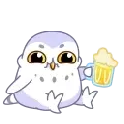

In [352]:
stikers = driver.find_elements(By.XPATH, "//div[contains(@class, 'sticker ng-star-inserted')]")
ss = []
i = 0
for s in stikers:
    stiker = s.find_elements(By.CSS_SELECTOR, '*')
    if stiker:
        if stiker[0].get_attribute('src'):
            ss.append(stiker[0])
    i += 1
    print(i)
    
    
#ss = [s[0] for s in ss if s]
sss = random.choice(list(set(ss)))
#print(len(ss), len(set(ss)))
img_stiker(sss)

In [351]:
sss = random.choice(list(set(ss)))
sss.get_attribute('src')

In [ ]:
sss.

In [347]:
print(len(ss), len(set(ss)))

285 285
